# Predicting Severity of Car Accidents  
**A machine learning study on Car Accidents Occurred in Seattle City**

# Table of Content  
[1. Introduction: Problem Understanding](#problem)  
[2. Data](#data)  
> [2.1. Data Understanding](#datUnd)  
  [2.2. Data Preprocessing](#datPre)  
  >> [2.2.1 Data Cleansing](#datClns)  
    [2.2.2 Data Wrangling](#datWrang)  

[3. Methodolgy](#method)  
> [3.1. Exploratory Data Analysis](#exp)  
  [3.2. Feature Selection and Feature Engineering](#feature)  
  [3.3. Modeling](#model)  
  [3.4. Model Evaluation](#eval)  
  
[4. Results & Discussion](#rd)  
[5. Conclusion](#conc)  

# 1. Introduction: Problem Understanding <a class="anchor" id="problem"></a>

Would it not be great if you could tell in advance how sever an accident will be if it occurs?! In this project, we will use a car-accident data of _Seatle city  in the Washington State, US_ from 2004 to 2013. The data  contains many useful features such as `WEATHER` (weather condition), `LIGHTCOND` (light condition), `X, Y` (latitude and longitude), `UNDERINFL` (whether the deriver is under the influence of alcohol). The severity of the accident is classified into several classes ranging from property damage to fatality, please see [Section 2.1](#datUnd). This problem is interesting for the Departments  of Transportation especially in the _Seattle City_. It can help the department linking weather, road and light conditions, certain locations and certain streets to very sever accidents.

At the end of this project, you should be able to tell how sever a collision is based on some of the features mentioned above.

# 2. Data <a class="anchor" id="data"></a>

## 2.1. Data Understanding <a class="anchor" id="datUnd"></a>

The data contains information about the car accidents occured in the Seattle city in the US  The data contains 221144 records and 40 attributes (features) which include the severity, coordinates, location of the accident, weather and light condition, wether the accident is due to speeding or under the influence of of alcohol. The data has a public open access and can be downloaded from the [city goverment website](https://data.seattle.gov/).

The features of the data are summarized in the following table:  

| Feature/Attribute | Description |
| :- | :- |
| SEVERITYCODE | A code that corresponds to the severity of the collision. **This is the target label** |
| X | The x-coordinate of the exact location of the collision |
| Y | The y-coordinate of the exact location of the collision |
| ObjectID | Unique identifier |
| INCKEY | A unique key for the incident |
| COLDETKEY | Secondary key for the incident |
| STATUS | NA |
| ADDRTYPE | Collision address type which can be _alley, block_ or _intersection_ |
| INTKEY | Key that corresponds to the intersection associated with a collision |
| LOCATION | Description of the general location of the collision |
| EXCEPTRSNCODE | NA |
| EXCEPTRSNDESC | NA |
| SEVERITYDESC | A detailed description of the severity of the collision |
| COLLISIONTYPE | Collision type |
| PERSONCOUNT | The total number of people involved in the collision |
| FATALITIES | The number of fatalities in the collision. This is entered by the state |
| INCDATE | The date of the incident |
| INCDTTM | The date and time of the incident |
| JUNCTIONTYPE | Category of junction at which collision took place |
| SDOT_COLCODE | A code given to the collision by SDOT |
| SDOT_COLDESC | A description of the collision corresponding to the collision code |
| INATTENTIONIND | Whether or not collision was due to inattention |
| UNDERINFL | Whether or not a driver involved was under the influence of drugs or alcohol |
| WEATHER | A description of the weather conditions during the time of the collision |
| ROADCOND | The condition of the road during the collision |
| LIGHTCOND | The light conditions during the collision |
| PEDROWNOTGRNT | Whether or not the pedestrian right of way was not granted |
| SDOTCOLNUM | A number given to the collision by SDOT |
| SPEEDING | Whether or not speeding was a factor in the collision |
| ST_COLCODE | A code provided by the state that describes the collision |
| ST_COLDESC | A description that corresponds to the state’s coding designation |
| SEGLANEKEY | A key for the lane segment in which the collision occurred |
| CROSSWALKKEY | A key for the crosswalk at which the collision occurred |
| HITPARKEDCAR | Whether or not the collision involved hitting a parked car |

**Important Notes:**  
- The target label `SEVERITYCODE` has multiple values. Therefore, we have a _multiclass classification_ problem.
- The target label takes the following values:

| Value | Description |
| :- | :- |
| 0 | Unknown |
| 1 | Property damage |
| 2 | Injury |
| 2b | Serious Injury |
| 3 | Fatality |

- The values of the target label are not equally represented in the dataset. Therefore, we have _imbalance classification problem_.  
- Not of all attributes are relevant for modeling such as various keys that are probably used to archiving and administrative purposes such as `OBJECTID` (a key for uniquely identifying collision), `REPORTNO` (a key for uniquely identifying the report of the collision), etc. These irrelevant attributes should be removed.
- The remaining attributes, though relevant, correlate with different degrees to the severity of the accident and thus, we still perform feature selection to select the most informative features and to prevent overfitting.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib as mp
import matplotlib.pyplot as plt
mp.style.use('ggplot')
%matplotlib inline
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [2]:
# Read data
df = pd.read_csv("/home/ahmed/Courses/Data_Science/Capstone/Collisions.csv")

How many features and observations we have:

In [3]:
print('The number of observation = %d and number of features = %d' %(df.shape))

The number of observation = 221144 and number of features = 40


In [4]:
# Check if all columns are of type string
all(isinstance(x, str) for x in df.columns)

True

How many classes and what is the distribution of these classes

In [5]:
df.SEVERITYCODE.value_counts().to_frame()

,SEVERITYCODE
1,137414
2,58665
0,21619
2b,3096
3,349


As can be observed the classes are not equally distributed and thus, we have an imbalanced classification. We will deal with this later.

## 2.2. Data Preprocessing <a class="anchor" id="datPre"></a>

### 2.2.1 Data Cleansing <a class="anchor" id="datClns"></a>

**Removing Irrelevant Information**  

From the table above, it can be observed that not all features are relevant for the machine learning model. These irrelevant features include several unique keys (OBJECTID, SDOT_COLCODE etc), the report number (REPORTNO), and description of the severity of the collision (SEVERITYDESC), etc.  

Please note that not all keys should be removed since some keys are _informative_ such as the intersection key (INTKEY) and lane key (SEGLANEKEY) which identify the intersection and the lane at which the collision occurs respectively.

In [6]:
df.drop(labels=['OBJECTID', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INCDATE', 'INCDTTM',\
                'SDOT_COLCODE','SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLDESC', 'HITPARKEDCAR',\
                'INCKEY', 'COLDETKEY', 'REPORTNO', 'SEVERITYDESC'], axis=1, inplace=True)
# see how many attributes remaining
print('The number of possibly relevant feature = %d' %(df.shape[1]))

The number of possibly relevant feature = 26


In [7]:
# Show the feature names
df.columns.values

array(['X', 'Y', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION',
       'SEVERITYCODE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'JUNCTIONTYPE', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING',
       'ST_COLCODE', 'SEGLANEKEY', 'CROSSWALKKEY'], dtype=object)

### Handling Missing Values


Missing values are handled as follows:
- Dropping a feature (dropping the entire column)  
This is done when the missing values are too many (above 50%). In this case, imputing values will likely generate inaccurate data that does not represent the real distribution of the corresponding feature.
- Droping a record (dropping the entire row)  
This is done for missing values of the target label.
- Replacing missing values with a roulette wheel selection  
For categorical features, the common practice is to replace the missing values with the most frequent one. However, I come up with a better way of replacing the missing values that is more likely to respect the underlined, unknown distribution from which the data was drawn. This is done by a **roulette wheel selection** in which the probability of a non-missing value to replace a missing value is proportional to the frequency of the non-missing value.
- Replace the missing value with the mean  
Write sth.

There are also some records the contain a value of __Unknown__ which we treat it as a missing value. Please note that we are aware of model-based missing-value imputation; however, we do not use it for two reasons:  
1. The percentage of missing value is generally low in most of the features (columns).
2. The simplicity of the roulette wheel replacement method together with its power in preserving the distribution of the data strongly calls for its employment as an a legitimate alternative. 

**Handling missing values of the target label**

In [8]:
# check if the target label has missing values
df.SEVERITYCODE.isnull().sum()

1

In [9]:
# remove the missing value from the target label
df.dropna(subset=['SEVERITYCODE'], axis=0, inplace=True)
# reset the indexes
df.reset_index(drop=True, inplace=True)
# check again
df.SEVERITYCODE.isnull().sum()

0

In [10]:
def displayna(dataFrame, threshold=0, showall=False):
    """
    Print the columns that has missing values above a threshold. If showall is True, all columns will be displayed
    regardless of the threshold.
    """
    missing_data = dataFrame.isnull()
    if missing_data.sum().sum() == 0:
        print('Great! There is no missing value!')
        return
    for column in missing_data.columns.values.tolist():    
        series = missing_data[column].value_counts()
        indexes = missing_data[column].value_counts().index.values.tolist()
        printed = False
        for idx in indexes:
            if showall or (idx and np.round(100*series.loc[idx]/dataFrame.shape[0]) > threshold):
                if(not printed): print("Column Name: ", column)
                print("Missing Value? ", idx, " Percentage: ", np.round(100*series.loc[idx]/dataFrame.shape[0]))
                printed = True
        if printed: print("")  

Handling columns with too many missing values (above 50%)

In [11]:
displayna(df, threshold=50)

Column Name:  INTKEY
Missing Value?  True  Percentage:  68.0

Column Name:  INATTENTIONIND
Missing Value?  True  Percentage:  86.0

Column Name:  PEDROWNOTGRNT
Missing Value?  True  Percentage:  98.0

Column Name:  SPEEDING
Missing Value?  True  Percentage:  96.0



In [12]:
# drop those columns
df.drop(labels=['INTKEY', 'INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING'], axis=1, inplace=True)
# check
print("The number of remaining features = ", df.shape[1])

The number of remaining features =  22


Check if there is any column with some missing values

In [13]:
displayna(df, showall=False)

Column Name:  X
Missing Value?  True  Percentage:  3.0

Column Name:  Y
Missing Value?  True  Percentage:  3.0

Column Name:  ADDRTYPE
Missing Value?  True  Percentage:  2.0

Column Name:  LOCATION
Missing Value?  True  Percentage:  2.0

Column Name:  COLLISIONTYPE
Missing Value?  True  Percentage:  12.0

Column Name:  JUNCTIONTYPE
Missing Value?  True  Percentage:  5.0

Column Name:  UNDERINFL
Missing Value?  True  Percentage:  12.0

Column Name:  WEATHER
Missing Value?  True  Percentage:  12.0

Column Name:  ROADCOND
Missing Value?  True  Percentage:  12.0

Column Name:  LIGHTCOND
Missing Value?  True  Percentage:  12.0

Column Name:  ST_COLCODE
Missing Value?  True  Percentage:  4.0



**Handling the missing values of the coordinates X and Y**

**Important note:**  

Based on the result above, we can conclude that:  
- Replacing a missing value with the mean does not make sense <font color="red"> since the mean in this case can corrspond to a location in which it is impossible to have a car accident</font> such as a lake, stream, etc. 
- There is no dominant values for X and Y and the likelihood of having an accident at a particular (X,Y)-location is very small. Therefore, it makes sense to replace the missing values for X and Y by a randomly selected values from X and Y. 

Define a little function for this purpose

In [14]:
def random_replacena(dataFrame, col):
    """
    Replace missing values with random values selected from the same series.
    """
    # Find the non-missing values
    series = dataFrame[pd.notna(dataFrame[col])][col]
    # Replace missing values at random
    dataFrame[col] = dataFrame[col].apply(lambda x: np.random.choice(series) if (pd.isna(x)) else x)
    # Check if there is no missing value
    if dataFrame[col].isna().sum() != 0:
        print('Error!')
    else:
        print('Successful!')

In [15]:
random_replacena(df, 'X')
random_replacena(df, 'Y')

Successful!
Successful!


**Handling missing values of the address type (ADDRTYPE)**

Replace the missing values with random values selected according to <font color="blue"> roulette wheel selection </font>. To do this, define a function for calculating the probability distribution:

In [16]:
def find_probs(data_frame, col):
    """
    Find the probability distribution of data_frame.col
    """
    counts = data_frame[col].value_counts().values
    total = sum(counts)
    probs = [float(x)/total for x in counts]
    return probs


def roulette_wheel_replacena(data_frame, col, show=False):
    probs = find_probs(data_frame, col)
    if show:
        print("Probability distribution BEFORE applying roulette wheel:")
        print([np.round(x, decimals=5) for x in probs])
    values = data_frame[col].value_counts().index.values.tolist()
    # Replace missing values using roulette wheel
    data_frame[col] = data_frame[col].apply(lambda x: np.random.choice(values, p=probs) if (pd.isna(x)) else x)
    # Check if there is no missing value
    if show:
        print("")
        print("Probability distribution AFTER applying roulette wheel:")
        print([np.round(x,decimals=5) for x in find_probs(data_frame, col)]) 
        print("")
    if data_frame[col].isna().sum() != 0:
        print('Error!')
    else:
        print('Successful!')    
    

In [17]:
roulette_wheel_replacena(df, 'ADDRTYPE', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.66588, 0.3301, 0.00402]

Probability distribution AFTER applying roulette wheel:
[0.66596, 0.33003, 0.00401]

Successful!


**Handling missing values of location (LOCATION)**  

This is a bit complicated.  
- The attribute `LOCATION` provides a description of the general location at which the collision occured.  
- Most of the data entries are of the form: <font color="blue"> Street A BETWEEN Street B and Street C </font>. 
- In reality, some streets are more prone to accident than others. For instance, a main busy road in the city is more likely to have accidents compared to a quiet road in a quiet neighborhood. 
- Furthermore, the _specific location_ along the street is usually of a secondary importance. This is confirmed by the data from the `value_counts` since there is no dominantly frequent values.  
- However, when the streets are considered as a whole _without partitioning the street_ as in the data, some streets appear to have significantly more accidents.

In [18]:
df.LOCATION.value_counts().to_frame().head(10)

,LOCATION
BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N,298
N NORTHGATE WAY BETWEEN MERIDIAN AVE N AND CORLISS AVE N,296
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB,291
AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,282
6TH AVE AND JAMES ST,276
AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST,270
RAINIER AVE S BETWEEN S BAYVIEW ST AND S MCCLELLAN ST,257
ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ON RP AND SENECA ST OFF RP,256
ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND ALASKAN WY VI SB EFR OFF RP,230
WEST SEATTLE BR EB BETWEEN ALASKAN WY VI NB ON RP AND DELRIDGE-W SEATTLE BR EB ON RP,225


Clearly there is no dominantly frequent location. Now, remove the street partition and _a street from its beginning to its end is considered_ as a **single entry**.

In [19]:
df['LOCATION'] = df['LOCATION'].apply(lambda x: (str(x).split('BETWEEN')[0]).strip() if "BETWEEN" in str(x) else x)

In [20]:
df.LOCATION.value_counts().to_frame().head(10)

,LOCATION
RAINIER AVE S,5712
AURORA AVE N,3896
1ST AVE S,1600
LAKE CITY WAY NE,1553
1ST AVE,1549
4TH AVE S,1413
DELRIDGE WAY SW,1383
EAST MARGINAL WAY S,1375
GREENWOOD AVE N,1251
NE 45TH ST,1175


Eureka! Some streets appear to have significantly more accidents compared to other streets. Those streets are among the 10 busiest streets in the Seattle city according to [this website](#https://mynorthwest.com/gallery/seattles-10-busiest-streets/). This pattern was not clearly apparent before.

In [21]:
# Now replace the missing values
roulette_wheel_replacena(df, 'LOCATION')

Successful!


**Fixing inconsistencies in locations (data-entry errors)**  

The location data also contains intersection in the form of __Street A AND Street B__ and it is possible that the same intersection is inconsistently represented by two distinct values: __Street A AND Street B__ and __Street B AND street A__. This needs to be rectified.

In [22]:
def fix_intersection():
    seen = set()
    dict_ = {}
    intersections = df[["AND" in x for x in df.LOCATION]]['LOCATION']
    intersections = list(map(str, intersections))
    for intsec in intersections:
        address = intsec.split("AND")
        address = (address[0].strip(), address[1].strip())    
        if (address[1], address[0]) in seen:
            dict_[intsec] = " " + address[1] + " AND " + address[0] + " "
            print("Inconsistency is found and is being dealt with:")
            print("-",intsec,"-")
            print("")
        seen.add(address)
    df.LOCATION.replace(to_replace=dict_, inplace=True)
    if len(list(dict_.keys())) == 0: print('Great! No inconsisteny is found.')

In [23]:
fix_intersection()

Inconsistency is found and is being dealt with:
- 22ND AVE NE AND 22ND WR AVE NE -

Inconsistency is found and is being dealt with:
- 22ND AVE NE AND 22ND WR AVE NE -



Call it again to see if it is fixed

In [24]:
fix_intersection()

Great! No inconsisteny is found.


**Handling missing values of the collision type (COLLISIONTYPE)**

In [25]:
df.COLLISIONTYPE.unique()

array([nan, 'Left Turn', 'Parked Car', 'Rear Ended', 'Angles',
       'Sideswipe', 'Other', 'Pedestrian', 'Right Turn', 'Head On',
       'Cycles'], dtype=object)

In [26]:
roulette_wheel_replacena(df, 'COLLISIONTYPE', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.2488, 0.18209, 0.17779, 0.12593, 0.09681, 0.0723, 0.0393, 0.03034, 0.01544, 0.0112]

Probability distribution AFTER applying roulette wheel:
[0.24911, 0.18144, 0.17817, 0.12581, 0.09683, 0.07224, 0.03936, 0.0303, 0.01558, 0.01116]

Successful!


**Handling missing values of junction type (JUNCTIONTYPE)**

In [27]:
df.JUNCTIONTYPE.value_counts().to_frame()

,JUNCTIONTYPE
Mid-Block (not related to intersection),101523
At Intersection (intersection related),69067
Mid-Block (but intersection related),24392
Driveway Junction,11493
At Intersection (but not related to intersection),2495
Ramp Junction,190
Unknown,21


**Important note**  
Notice that there are 22 values that are __Unknown__. These values can be treated as the same as missing values. Therefore, let us convert them to `numpy.nan` (missing values). Then, we can replace these missing values using the roulette-wheel selection approach as shown above.

In [28]:
df.JUNCTIONTYPE = df.JUNCTIONTYPE.replace(to_replace={'Unknown':np.nan})

In [29]:
roulette_wheel_replacena(df, 'JUNCTIONTYPE', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.48538, 0.33021, 0.11662, 0.05495, 0.01193, 0.00091]

Probability distribution AFTER applying roulette wheel:
[0.48529, 0.33043, 0.11683, 0.0547, 0.01184, 0.00091]

Successful!


**Handling missing values of whether the driver was under the influence of alcohol (UNDERINFL)**

In [30]:
df.UNDERINFL.value_counts().to_frame()

,UNDERINFL
N,103454
0,81676
Y,5399
1,4230


According to the data source, the attribute UNDERINFL is binary which has two value: "Y" to indicate that the driver was under the influence of alcohol and "N" for negating that. 
It appears that the data entries are not consistent. We need to __convert "Y" to 1 and "N" to 0__

In [31]:
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace={"N": "0", "Y":"1"})
# Check 
df.UNDERINFL.value_counts().to_frame()

,UNDERINFL
0,185130
1,9629


In [32]:
roulette_wheel_replacena(df, 'UNDERINFL', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.95056, 0.04944]

Probability distribution AFTER applying roulette wheel:
[0.9505, 0.0495]

Successful!


**Handling missing values of weather (WEATHER)**

In [33]:
df.WEATHER.value_counts().to_frame()

,WEATHER
Clear,114342
Raining,34019
Overcast,28503
Unknown,15131
Snowing,919
Other,851
Fog/Smog/Smoke,577
Sleet/Hail/Freezing Rain,116
Blowing Sand/Dirt,56
Severe Crosswind,26


First, convert the records with a value of **Unknown** to `numpy.nan`to treat it as a missing value. Then, deal with it!

In [34]:
df.WEATHER = df.WEATHER.replace(to_replace={'Unknown':np.nan})

In [35]:
roulette_wheel_replacena(df, 'WEATHER', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.63729, 0.18961, 0.15886, 0.00512, 0.00474, 0.00322, 0.00065, 0.00031, 0.00014, 5e-05, 1e-05]

Probability distribution AFTER applying roulette wheel:
[0.63635, 0.19009, 0.15931, 0.00511, 0.00471, 0.00326, 0.00066, 0.00031, 0.00013, 7e-05, 0.0]

Successful!


**Handling missing values of road condition (ROADCOND)**

In [36]:
df.ROADCOND.value_counts()

Dry               128150
Wet                48710
Unknown            15129
Ice                 1231
Snow/Slush          1014
Other                136
Standing Water       119
Sand/Mud/Dirt         77
Oil                   64
Name: ROADCOND, dtype: int64

Deal with the unknowns then deal with the missing values

In [37]:
df.ROADCOND = df.ROADCOND.replace(to_replace={'Unknown':np.nan})

In [38]:
roulette_wheel_replacena(df, 'ROADCOND', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.71392, 0.27136, 0.00686, 0.00565, 0.00076, 0.00066, 0.00043, 0.00036]

Probability distribution AFTER applying roulette wheel:
[0.71367, 0.2716, 0.0068, 0.00578, 0.00076, 0.00065, 0.0004, 0.00035]

Successful!


**Handling missing values of light condition (LIGHTCOND)**

In [39]:
df.LIGHTCOND.value_counts().to_frame()

,LIGHTCOND
Daylight,119148
Dark - Street Lights On,50048
Unknown,13520
Dusk,6074
Dawn,2599
Dark - No Street Lights,1573
Dark - Street Lights Off,1236
Other,244
Dark - Unknown Lighting,20


Deal with the unknowns, then deal with the missing values

In [40]:
# First convert "Unknown" to nan
df['LIGHTCOND'] = df['LIGHTCOND'].replace(to_replace="Unknown", value=np.nan)
# Replace the missing values using the roulette wheel selection
roulette_wheel_replacena(df, 'LIGHTCOND', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.65849, 0.2766, 0.03357, 0.01436, 0.00869, 0.00683, 0.00135, 0.00011]

Probability distribution AFTER applying roulette wheel:
[0.65792, 0.27691, 0.03368, 0.01435, 0.00877, 0.00687, 0.00137, 0.00012]

Successful!


**Handling the missing values of the the state code (ST_COLCODE)**

In [41]:
df.ST_COLCODE.value_counts().to_frame()

,ST_COLCODE
32,44838
10,35460
14,26158
,16991
50,14117
...,...
43,3
87,2
49,1
85,1


The third entry represents missing values. Let us have a closer look to see how these missing values are enetered

In [42]:
df.ST_COLCODE.value_counts().index[3]

' '

In [43]:
df.ST_COLCODE = df.ST_COLCODE.replace(to_replace={' ': np.nan})

In [44]:
roulette_wheel_replacena(df, 'ST_COLCODE', show=False)

Successful!


**Great! All missing values have been handled!** Do one last check that the data is free of missing values

In [45]:
displayna(df)

Great! There is no missing value!


## Data Wrangling <a class="anchor" id="datWrang"></a>

In this section, we normalize the data and transform it into a format that is more convenient for the machine learning algorithms

**Preprocessing Categorical Features** 
The data contains several categorical features which requires conversion to appropriate format for the machine learning algorithm. There are several _categorical encoders_ to achieve this conversion. In the following table, we presented the encoders that are used in this study and the justification for their employment.

|Solution | Description | Usage |
|:- | :- | :- |  
Oridnal coding | Assign a unique integer for each string | Not used in this study as it induces unmeaningful order in our case. |
One-hot encoding | Generate a column of binaries for each level in the category | Used when the number of level per categorical variable is not very large. |
| Binary encoder | Conver the levels into binary strings and split them in columns | Used when the number of levels is very large since it generate fewers additional columns compared to the one-hot encoding and showed good performance in prior studies. |

In [46]:
df.SEVERITYCODE.value_counts().to_frame()

,SEVERITYCODE
1,137414
2,58665
0,21619
2b,3096
3,349


Replace non-numeric values

In [47]:
df.replace(to_replace={"3": "4"}, inplace=True)
df.replace(to_replace={"2b":"3"}, inplace=True)
df.SEVERITYCODE.value_counts().to_frame()

,SEVERITYCODE
1,137414
2,58665
0,21619
3,3096
4,349


In [48]:
# First let us check the data types of the features and correct it if necessary
df['SEVERITYCODE'].dtypes

dtype('O')

The type of SEVERITYCODE is `Object`. Let us convert it to `int` to make it readily useable for the analysis.

In [49]:
df['SEVERITYCODE'] = df['SEVERITYCODE'].astype('int', copy=True)

**Address Type**  

In [50]:
df.ADDRTYPE.value_counts().to_frame()

,ADDRTYPE
Block,147273
Intersection,72983
Alley,887


<AxesSubplot:xlabel='ADDRTYPE', ylabel='SEVERITYCODE'>

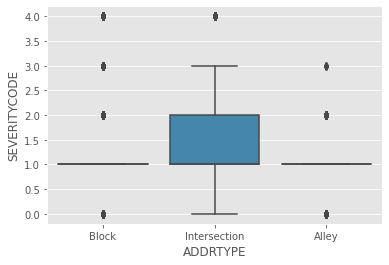

In [51]:
sns.boxplot(x="ADDRTYPE", y="SEVERITYCODE", data=df)

The address type has three levels. Therefore, using the one-hot encoding is sensible. 

In [52]:
# One-hot encoding
dum_df = pd.get_dummies(df.ADDRTYPE)
dum_df = dum_df.rename(lambda x: 'AddType-' + str(x), axis=1)
dum_df.head(2)

,AddType-Alley,AddType-Block,AddType-Intersection
0,0,1,0
1,0,0,1


In [53]:
# Add the new features to the data frame
df = pd.concat([df, dum_df], axis=1)
# Drop the original column
df.drop(labels="ADDRTYPE", axis=1, inplace=True)

**Status** 

In [54]:
df.STATUS.value_counts().to_frame()

,STATUS
Matched,194812
Unmatched,26331


In [55]:
lb_ec = LabelEncoder()
lb_ec.fit(['Matched', 'Unmatched'])
df.STATUS = lb_ec.fit_transform(df['STATUS'])
#check if the new feature is added
df.STATUS.value_counts().to_frame()

,STATUS
0,194812
1,26331


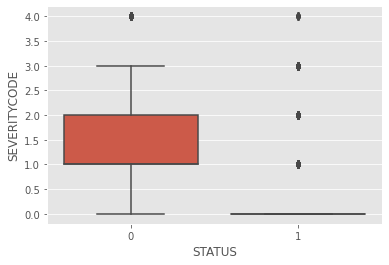

In [56]:
ax = sns.boxplot(x="STATUS", y="SEVERITYCODE", data=df)

---  
**NUmber of Pedestrians (PEDCOUNT)**

In [57]:
df.PEDCOUNT.value_counts().to_frame()

,PEDCOUNT
0,213084
1,7745
2,274
3,28
4,9
5,2
6,1


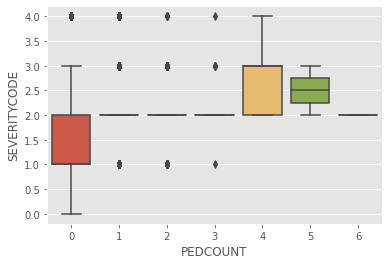

In [58]:
ax = sns.boxplot(x="PEDCOUNT", y="SEVERITYCODE", data=df)

**Number of persons involved in the collisions (PERSONCOUNT)**

In [59]:
x = df.PERSONCOUNT.value_counts()
print('How many different values? ', x.index.values.size)
print('Ranging from %d to %d' %(x.index.values[0], x.index.values[-1]))

How many different values?  48
Ranging from 2 to 93


Therefore, there are 48 different values for `PERSONCOUNT` ranging from to  2 to 93 ... . 

In [60]:
# Define non-uniform bins
bins = [0, 1, 2, 3, 4, 5, 10, 20, df.PERSONCOUNT.max()+0.01]
labels = ['PERCOUNT-'+str(x) for x in list(range(5)) + ['5-10', '10-20', 'More-20']]
df['PERSONCOUNT-BINNED'] = pd.cut(df.PERSONCOUNT, bins=bins, labels=labels, include_lowest=True, right=False)

In [61]:
df['PERSONCOUNT-BINNED'].unique()

[PERCOUNT-0, PERCOUNT-2, PERCOUNT-4, PERCOUNT-3, PERCOUNT-1, PERCOUNT-5-10, PERCOUNT-10-20, PERCOUNT-More-20]
Categories (8, object): [PERCOUNT-0 < PERCOUNT-1 < PERCOUNT-2 < PERCOUNT-3 < PERCOUNT-4 < PERCOUNT-5-10 < PERCOUNT-10-20 < PERCOUNT-More-20]

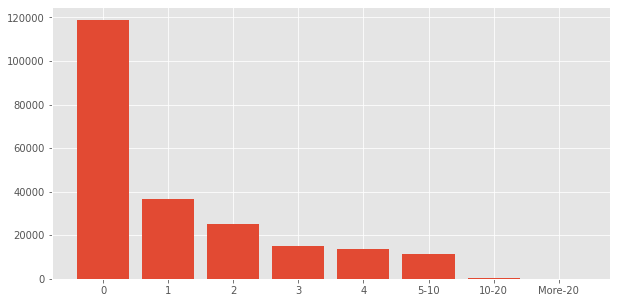

In [62]:
fig = plt.figure(figsize=(10,5))
bar = plt.bar(df['PERSONCOUNT-BINNED'].value_counts().index.to_list(), df['PERSONCOUNT-BINNED'].value_counts(),
        tick_label=[0,1,2,3,4,'5-10', '10-20', 'More-20'])

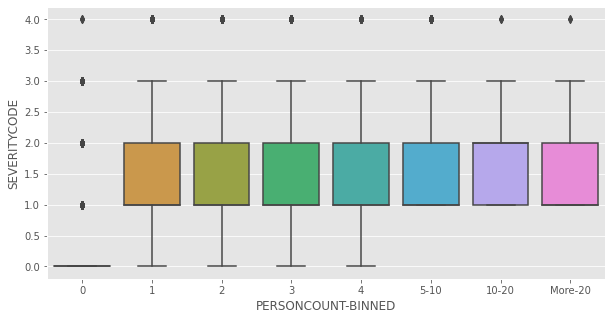

In [63]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x="PERSONCOUNT-BINNED", y="SEVERITYCODE", data=df)
lb = ax.set_xticklabels(['0','1','2','3','4','5-10', '10-20', 'More-20'])

In [64]:
dfx = pd.get_dummies(df['PERSONCOUNT-BINNED'])
df = pd.concat([df, dfx], axis=1)
df.columns[-8:]

Index(['PERCOUNT-0', 'PERCOUNT-1', 'PERCOUNT-2', 'PERCOUNT-3', 'PERCOUNT-4',
       'PERCOUNT-5-10', 'PERCOUNT-10-20', 'PERCOUNT-More-20'],
      dtype='object')

In [65]:
# Drop the original column
df.drop('PERSONCOUNT-BINNED', axis=1, inplace=True)

---  
**Number of Injured Persons (INJURIES)**

In [66]:
df.INJURIES.value_counts().to_frame()

,INJURIES
0,159267
1,47210
2,10673
3,2728
4,814
5,273
6,100
7,40
8,12
9,10


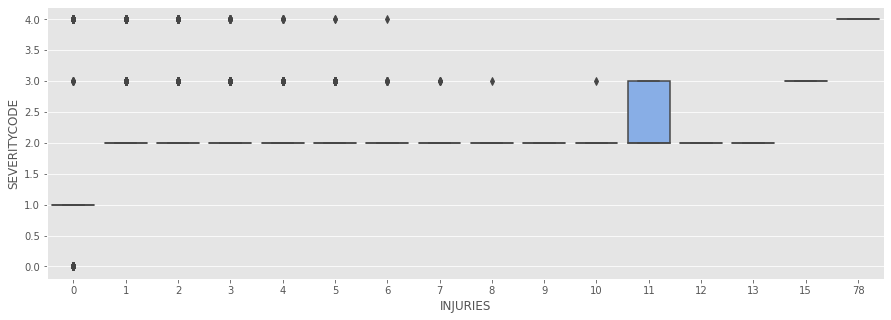

In [67]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='INJURIES', y='SEVERITYCODE', data=df)

In [68]:
bins = [0, 1, 7, 10, 80]
labels=['INJ-'+str(x) for x in [0, '1-6', '7-10', 'More-10']]
df['INJURIES-BINNED'] = pd.cut(df.INJURIES, bins=bins, labels=labels, include_lowest=True, right=False)
df.columns[-2:]

Index(['PERCOUNT-More-20', 'INJURIES-BINNED'], dtype='object')

<BarContainer object of 4 artists>

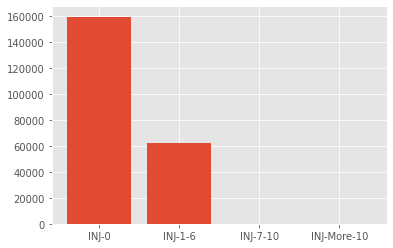

In [69]:
plt.bar(df['INJURIES-BINNED'].value_counts().index.to_list(), df['INJURIES-BINNED'].value_counts().values)

In [70]:
dfx = pd.get_dummies(df['INJURIES-BINNED'])
df = pd.concat([df, dfx], axis=1)
df.columns[-4:]

Index(['INJ-0', 'INJ-1-6', 'INJ-7-10', 'INJ-More-10'], dtype='object')

In [71]:
df.drop('INJURIES-BINNED', axis=1, inplace=True)

--- 
**Number of Seriously Injured Persons (SERIOUSINJURIED)**

In [72]:
df.SERIOUSINJURIES.value_counts().to_frame()

,SERIOUSINJURIES
0,218048
1,2927
2,133
3,23
4,6
5,5
41,1


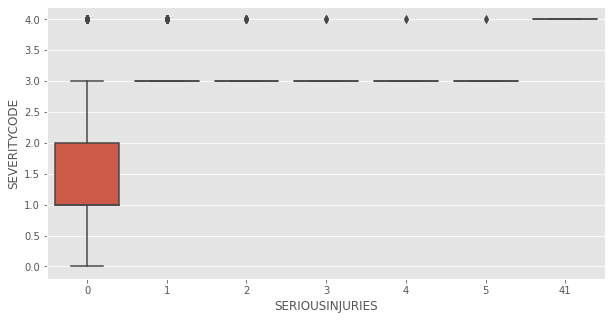

In [73]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='SERIOUSINJURIES', y='SEVERITYCODE', data=df)

In [74]:
bins = [0,1,2,3,45]
labels = ['SERINJ-0', 'SERINJ-1', 'SERINJ-2', 'SERINJ-3-MORE']
df['SERINJ-BINNED'] = pd.cut(df.SERIOUSINJURIES, bins=bins, labels=labels, include_lowest=True, right=False)
df.columns[-1]

'SERINJ-BINNED'

In [75]:
df['SERINJ-BINNED'].value_counts().to_frame()

,SERINJ-BINNED
SERINJ-0,218048
SERINJ-1,2927
SERINJ-2,133
SERINJ-3-MORE,35


In [76]:
dfx = pd.get_dummies(df['SERINJ-BINNED'])
df = pd.concat([df, dfx], axis=1)
df.columns[-4:]

Index(['SERINJ-0', 'SERINJ-1', 'SERINJ-2', 'SERINJ-3-MORE'], dtype='object')

In [77]:
df.drop('SERINJ-BINNED', axis=1, inplace=True)

---
**The Number of Bicycles Involved in the Collision (PEDCYLCOUNT)**

In [78]:
df.PEDCYLCOUNT.value_counts().to_frame()

,PEDCYLCOUNT
0,215158
1,5934
2,51


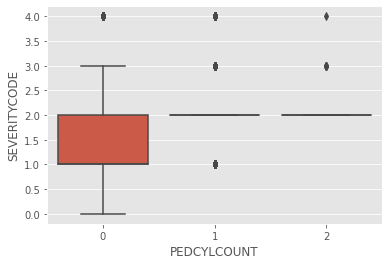

In [79]:
ax = sns.boxplot(x='PEDCYLCOUNT', y='SEVERITYCODE', data=df)

In [80]:
df.LOCATION.unique().size

9969

In [81]:
frame = df.LOCATION.value_counts().to_frame()
frame.head(10)

,LOCATION
RAINIER AVE S,5847
AURORA AVE N,3979
1ST AVE S,1638
1ST AVE,1590
LAKE CITY WAY NE,1586
4TH AVE S,1440
DELRIDGE WAY SW,1417
EAST MARGINAL WAY S,1404
GREENWOOD AVE N,1294
NE 45TH ST,1199


In [82]:
encoder = ce.BinaryEncoder(cols=['LOCATION'], return_df=True)
loc_encoded = encoder.fit_transform(df['LOCATION'])

In [83]:
print('The number of additional features = ', len(encoder.get_feature_names()))

The number of additional features =  15


In [84]:
#encoder.base_n_encoder.get_params()['mapping'][0]['mapping']

**Important Remark**  
As you can see above, the binary encoder incur only 15 additional features which are much more better than the 9969 additional features that would have been generated if the one-hot encoding is used.

In [85]:
dfx = pd.concat([df[['SEVERITYCODE']], loc_encoded], axis=1)

In [86]:
dfx.corr()[['SEVERITYCODE']]

,SEVERITYCODE
SEVERITYCODE,1.000000
LOCATION_0,NaN
LOCATION_1,0.002896
LOCATION_2,0.051106
LOCATION_3,0.029846
LOCATION_4,0.021142
LOCATION_5,-0.002222
LOCATION_6,-0.010322
LOCATION_7,0.003012
LOCATION_8,-0.001929


**Important Design Decision**  

In general the geographic data should not be ignored since it can be associated with certain patterns that can assist the machine learning algorithm to learn better. In this study, however, the geographic data can be safely ingnored since it is _weakly correlated_ with the target label. Consequently, it does not encapsulate sufficient information to justify including 14 more features in the model which, in turn, will induce a higher learning cost.

In [87]:
df.drop(labels=['X', 'Y', 'LOCATION'], axis=1, inplace=True)

--- 
**Category of the junction type at which the collision took place** 

In [88]:
df.JUNCTIONTYPE.value_counts().to_frame()

,JUNCTIONTYPE
Mid-Block (not related to intersection),107318
At Intersection (intersection related),73073
Mid-Block (but intersection related),25836
Driveway Junction,12097
At Intersection (but not related to intersection),2618
Ramp Junction,201


In [89]:
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace(to_replace={"Unknown":np.nan})
roulette_wheel_replacena(df, 'JUNCTIONTYPE', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.48529, 0.33043, 0.11683, 0.0547, 0.01184, 0.00091]

Probability distribution AFTER applying roulette wheel:
[0.48529, 0.33043, 0.11683, 0.0547, 0.01184, 0.00091]

Successful!


In [90]:
displayna(df)

Great! There is no missing value!


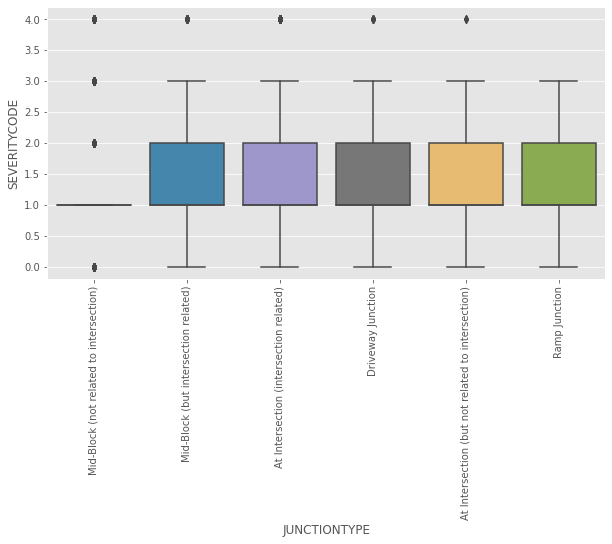

In [91]:
fig = plt.figure(figsize=(10,5))
ax = sns.boxplot(x="JUNCTIONTYPE", y="SEVERITYCODE", data=df)
tk = plt.xticks(rotation=90)

In [92]:
junc = pd.get_dummies(df.JUNCTIONTYPE)

rename_dict = {"Mid-Block (not related to intersection)": "Mid-Block-NoIntSc",
         "At Intersection (intersection related)": "Intersection-Intsc",
         "Mid-Block (but intersection related)": "Mid-Block-Intsc",
         "At Intersection (but not related to intersection)": "Intersection-NoIntsc"}

junc.rename(columns=rename_dict, inplace=True)

In [93]:
df = pd.concat([df, junc], axis=1)
#df.drop(labels='JUNCTIONTYPE', axis=1, inplace=True)
df.columns[-6:]

Index(['Intersection-NoIntsc', 'Intersection-Intsc', 'Driveway Junction',
       'Mid-Block-Intsc', 'Mid-Block-NoIntSc', 'Ramp Junction'],
      dtype='object')

In [94]:
df.columns[-6:]

Index(['Intersection-NoIntsc', 'Intersection-Intsc', 'Driveway Junction',
       'Mid-Block-Intsc', 'Mid-Block-NoIntSc', 'Ramp Junction'],
      dtype='object')

In [95]:
df.drop('JUNCTIONTYPE', axis=1, inplace=True)

---  
**Number of vehicle involved in the collision**

In [96]:
df.VEHCOUNT.value_counts().to_frame()

,VEHCOUNT
2,150038
1,27821
0,26628
3,13340
4,2513
5,557
6,153
7,53
8,18
9,10


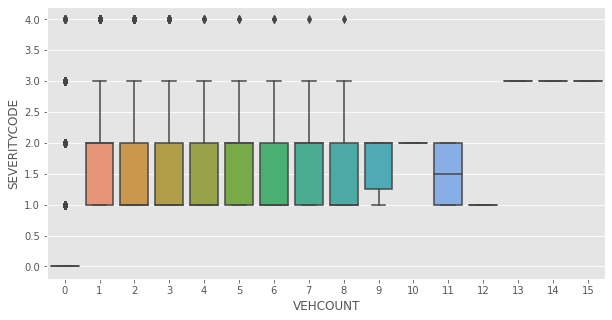

In [97]:
fig = plt.figure(figsize=(10,5))
ax = sns.boxplot(x='VEHCOUNT', y='SEVERITYCODE', data=df)

The boxplot reveals that the following observations:  

- Collisions involving one up to 8 cars have the same distribution for the severity code. Therefore, can be grouped in one category.
- There are very few collisions involving more than 8 cars. For instance, there is only one collision involving 12 cars and the severity of this collision could very well be random. Therefore, collisions with more than 8 cars are grouped in one category.

In [98]:
# Define non-uniform bins
bins = [0, 1, 9, df.VEHCOUNT.max()+1]
labels = ['VEHCOUNT-'+str(x) for x in ['0', '1-8', 'More-8']]
df['VEHCOUNT-BINNED'] = pd.cut(df.VEHCOUNT, bins=bins, labels=labels, include_lowest=True, right=False)

In [99]:
df['VEHCOUNT-BINNED'].value_counts().to_frame()

,VEHCOUNT-BINNED
VEHCOUNT-1-8,194493
VEHCOUNT-0,26628
VEHCOUNT-More-8,22


In [100]:
dfx = pd.get_dummies(df['VEHCOUNT-BINNED'])
df = pd.concat([df, dfx], axis=1)
df.columns[-3:]

Index(['VEHCOUNT-0', 'VEHCOUNT-1-8', 'VEHCOUNT-More-8'], dtype='object')

In [101]:
df.drop('VEHCOUNT-BINNED', axis=1, inplace=True)

---  
**Number of fatalities in the collision**

In [102]:
df.FATALITIES.value_counts().to_frame()

,FATALITIES
0,220794
1,333
2,12
3,2
5,1
4,1


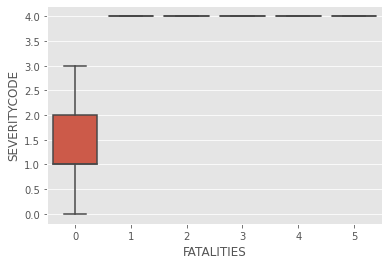

In [103]:
ax = sns.boxplot(x='FATALITIES', y='SEVERITYCODE', data=df)

---  
**Weather condition when the collision occurred**

In [104]:
df.WEATHER.value_counts().to_frame()

,WEATHER
Clear,140724
Raining,42038
Overcast,35230
Snowing,1131
Other,1041
Fog/Smog/Smoke,721
Sleet/Hail/Freezing Rain,145
Blowing Sand/Dirt,68
Severe Crosswind,29
Partly Cloudy,15


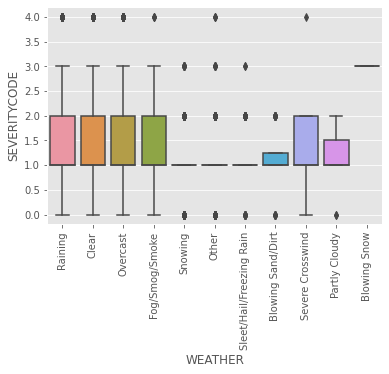

In [105]:
ax = sns.boxplot(x='WEATHER', y='SEVERITYCODE', data=df)
tk = plt.xticks(rotation=90)

In [106]:
df['WEATHER'] = df['WEATHER'].replace(to_replace={"Unknown":np.nan})
displayna(df)

Great! There is no missing value!


In [107]:
roulette_wheel_replacena(df, 'WEATHER', show=True)

Probability distribution BEFORE applying roulette wheel:
[0.63635, 0.19009, 0.15931, 0.00511, 0.00471, 0.00326, 0.00066, 0.00031, 0.00013, 7e-05, 0.0]

Probability distribution AFTER applying roulette wheel:
[0.63635, 0.19009, 0.15931, 0.00511, 0.00471, 0.00326, 0.00066, 0.00031, 0.00013, 7e-05, 0.0]

Successful!


In [108]:
dfx = pd.get_dummies(df.WEATHER)
df = pd.concat([df, dfx], axis=1)
df.columns[-10:]

Index(['Blowing Snow', 'Clear', 'Fog/Smog/Smoke', 'Other', 'Overcast',
       'Partly Cloudy', 'Raining', 'Severe Crosswind',
       'Sleet/Hail/Freezing Rain', 'Snowing'],
      dtype='object')

In [109]:
df.drop('WEATHER', axis=1, inplace=True)

**Light condition (LIGHTCOND)**

In [110]:
df.LIGHTCOND.value_counts().to_frame()

,LIGHTCOND
Daylight,145494
Dark - Street Lights On,61236
Dusk,7449
Dawn,3174
Dark - No Street Lights,1940
Dark - Street Lights Off,1519
Other,304
Dark - Unknown Lighting,27


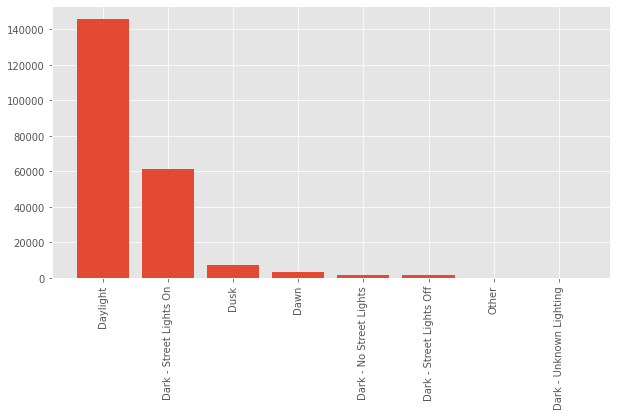

In [111]:
fig = plt.figure(figsize=(10,5))
bar = plt.bar(df['LIGHTCOND'].value_counts().index.to_list(), df['LIGHTCOND'].value_counts())
tk = plt.xticks(rotation=90)

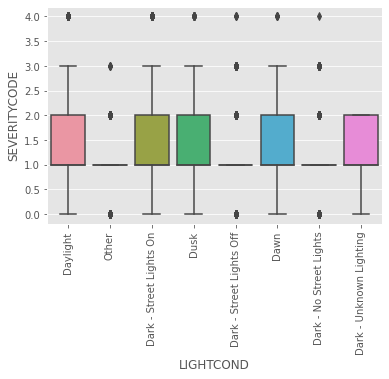

In [112]:
ax = sns.boxplot(x='LIGHTCOND', y='SEVERITYCODE', data=df)
tks = plt.xticks(rotation=90)

In [113]:
dfx = pd.get_dummies(df.LIGHTCOND)
df = pd.concat([df, dfx], axis=1)

In [114]:
df.drop('LIGHTCOND', axis=1, inplace=True)

**Road condition (ROADCOND)**

In [115]:
df.ROADCOND.value_counts().to_frame()

,ROADCOND
Dry,157824
Wet,60062
Ice,1503
Snow/Slush,1278
Other,167
Standing Water,143
Sand/Mud/Dirt,89
Oil,77


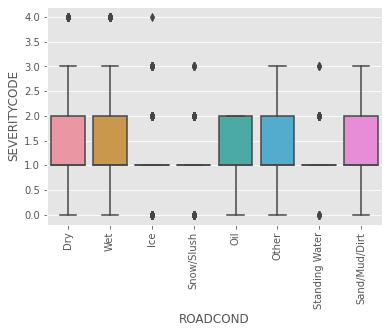

In [116]:
ax = sns.boxplot(x='ROADCOND', y='SEVERITYCODE', data=df)
tks = plt.xticks(rotation=90)

In [117]:
dfx = pd.get_dummies(df.ROADCOND)
df = pd.concat([df, dfx], axis=1)

In [118]:
df.drop(labels='ROADCOND', axis=1, inplace=True)

**Under influence of alcohol (UNDERINFL)**  

In [119]:
df.UNDERINFL.value_counts().to_frame()

,UNDERINFL
0,210196
1,10947


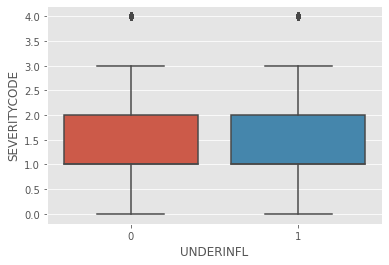

In [120]:
ax = sns.boxplot(x='UNDERINFL', y='SEVERITYCODE', data=df)

The boxplot reveals a shocking discovery! The severity of the collision is indepdendent of whether the driver is under the influence of the alcohol or not. 

For this reason, the feature `UNDERINFL` is not predictive of the severity of the collision and thus should be dropped.

In [121]:
df.drop('UNDERINFL', axis=1, inplace=True)

**The lane at which the collision occurred (SEGLANEKEY)**

In [122]:
df.SEGLANEKEY.value_counts().to_frame()

,SEGLANEKEY
0,218107
6532,19
6078,19
12162,18
10336,15
...,...
9803,1
14281,1
4178,1
6355,1


In [123]:
df['SEGLANEKEY'] = df['SEGLANEKEY'].apply(lambda x: x if x == 0 else 1)

In [124]:
df.SEGLANEKEY.value_counts().to_frame()

,SEGLANEKEY
0,218107
1,3036


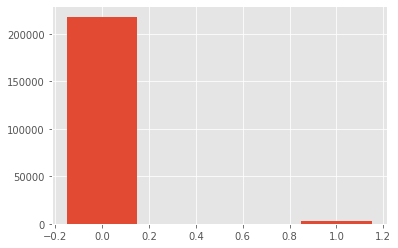

In [125]:
bar = plt.bar(df.SEGLANEKEY.value_counts().index.to_list(), df.SEGLANEKEY.value_counts(), width=0.3)

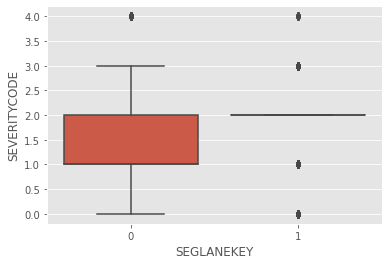

In [126]:
ax = sns.boxplot(x='SEGLANEKEY', y='SEVERITYCODE', data=df)

**Cross walk (CROSSWALKKEY)**

In [127]:
df.CROSSWALKKEY.value_counts().to_frame()

,CROSSWALKKEY
0,216902
523609,19
520838,15
524265,13
525567,13
...,...
525111,1
523080,1
521033,1
523208,1


In [128]:
df.CROSSWALKKEY = df.CROSSWALKKEY.apply(lambda x: x if x==0 else 1)

In [129]:
df.CROSSWALKKEY.value_counts().to_frame()

,CROSSWALKKEY
0,216902
1,4241


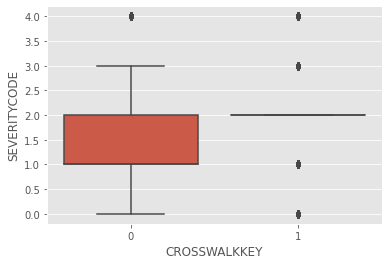

In [130]:
ax = sns.boxplot(x='CROSSWALKKEY', y='SEVERITYCODE', data=df)

**Collision type (COLLISIONTYPE)**

In [131]:
df.COLLISIONTYPE.value_counts().to_frame()

,COLLISIONTYPE
Parked Car,55089
Angles,40125
Rear Ended,39402
Other,27821
Sideswipe,21413
Left Turn,15976
Pedestrian,8704
Cycles,6701
Right Turn,3445
Head On,2467


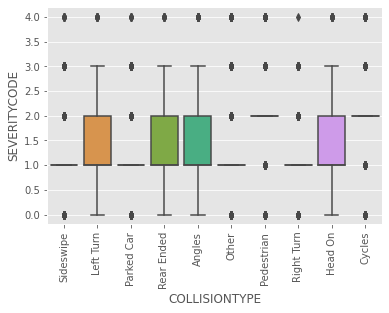

In [132]:
ax = sns.boxplot(x='COLLISIONTYPE', y='SEVERITYCODE', data=df)
tk = plt.xticks(rotation=90)

In [133]:
dum_df = pd.get_dummies(df.COLLISIONTYPE)
# Rename the columns by prefexing 'ColType-'
dum_df = dum_df.rename(lambda x: 'ColType-' + str(x), axis=1)
df = pd.concat([df, dum_df], axis=1)
df.columns[-10:]

Index(['ColType-Angles', 'ColType-Cycles', 'ColType-Head On',
       'ColType-Left Turn', 'ColType-Other', 'ColType-Parked Car',
       'ColType-Pedestrian', 'ColType-Rear Ended', 'ColType-Right Turn',
       'ColType-Sideswipe'],
      dtype='object')

In [134]:
df.drop('COLLISIONTYPE', axis=1, inplace=True)

In [135]:
dfx = df[['SEVERITYCODE'] + list(map(str, df.columns[-10:]))]

In [136]:
dfx.corr()[['SEVERITYCODE']]

,SEVERITYCODE
SEVERITYCODE,1.000000
ColType-Angles,0.056847
ColType-Cycles,0.156767
ColType-Head On,0.030142
ColType-Left Turn,0.039076
ColType-Other,-0.014425
ColType-Parked Car,-0.220175
ColType-Pedestrian,0.205251
ColType-Rear Ended,0.069254
ColType-Right Turn,-0.021133


---  
**State Code**

<BarContainer object of 46 artists>

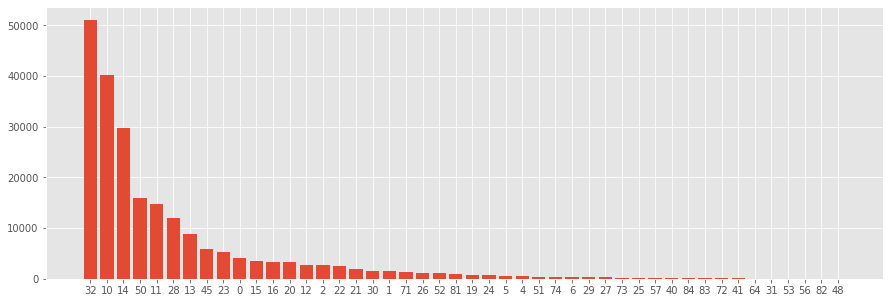

In [137]:
plt.figure(figsize=(15,5))
plt.bar(df.ST_COLCODE.value_counts().index.to_list()[:-15], df.ST_COLCODE.value_counts().values[:-15])

From the figure above, there are some state codes that are far more frequent. The following table summarizes these codes together with their description  

| State Code | Description |  
| :- | :- |
| 32 | One Parked - One Moving |
| 10 | Entering At Angle |
| 14 | From Same Direction - Both Going Straight - One Stopped - Rear End |
| 50 | Struck Fixed Object |
| 11 | From Same Direction - Both Going Straight-Both Moving- Sideswipe |
| 28 | From Opposite Direction - One Left Turn - One Straight |
| 13 | From Same Direction - Both Going Straight - Both Moving - Rear End |
| 45 | Bicycle |
| 23 | From Same Direction - All Others |
| 0 | Vehicle Going Straight Hits Pedestrian |
| 15 | From Same Direction - One Left Turn - One Straight |
| 16 | From Same Direction - One Right Turn - One Straight |
| 20 | One Car Leaving Parked Position |
| 12 | From Same Direction -Both Going Straight-One Stopped- Sideswipe |
| 2 | Vehicle Turning Left Hits Pedestrian |
| 22 | One Car Leaving Driveway Access |
| 21 | One Car Entering Driveway Access |


In [138]:
# Convert the data type from Object to int
df.ST_COLCODE = df.ST_COLCODE.astype('int')

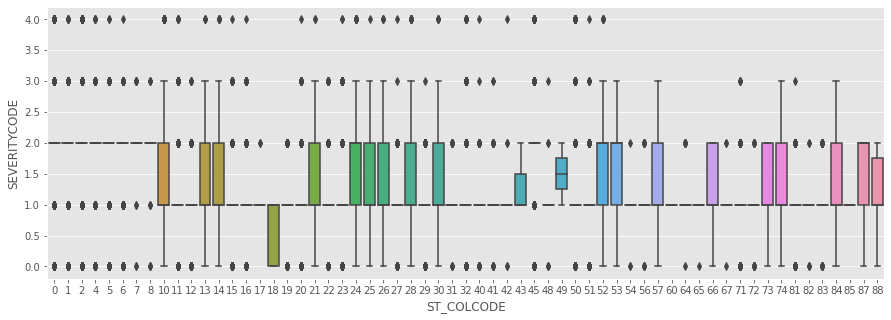

In [139]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='ST_COLCODE', y='SEVERITYCODE', data=df)

In [140]:
# Let focus on the 10 most frequent state codes
n = 10 # Number of codes
dfx=df[df.ST_COLCODE.isin(df.ST_COLCODE.value_counts().index.to_list()[:n])][['ST_COLCODE', 'SEVERITYCODE']] # Notice the double [] at the end
dfx.head(2)

,ST_COLCODE,SEVERITYCODE
0,10,0
1,14,0


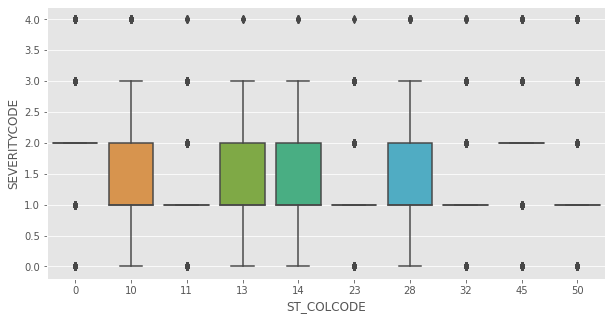

In [141]:
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='ST_COLCODE', y='SEVERITYCODE', data=dfx)

In [142]:
# Combine any code with frequency less than 1000 in one category
# Largest code is 84. Therefore, the less frequent codes are replaced by 99
freq_values = df.ST_COLCODE.value_counts().index.to_list()[:22]
df.ST_COLCODE = df.ST_COLCODE.apply(lambda x: x if x in freq_values else 99)

In [143]:
len(df.ST_COLCODE.unique())

23

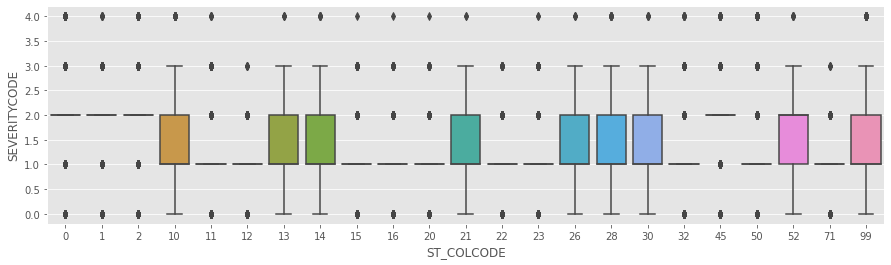

In [144]:
plt.figure(figsize=(15,4))
ax = sns.boxplot(x='ST_COLCODE', y='SEVERITYCODE', data=df)

In [145]:
bce = ce.BinaryEncoder(cols=['ST_COLCODE'], return_df=True)
dfx = bce.fit_transform(df.ST_COLCODE, return_df=True)
dfx.head(2)

,ST_COLCODE_0,ST_COLCODE_1,ST_COLCODE_2,ST_COLCODE_3,ST_COLCODE_4,ST_COLCODE_5
0,0,0,0,0,0,1
1,0,0,0,0,1,0


In [146]:
df = pd.concat([df, dfx], axis=1)
df.columns[-6:]

Index(['ST_COLCODE_0', 'ST_COLCODE_1', 'ST_COLCODE_2', 'ST_COLCODE_3',
       'ST_COLCODE_4', 'ST_COLCODE_5'],
      dtype='object')

In [147]:
dfx = pd.concat([df[['SEVERITYCODE']], dfx], axis=1)
dfx.corr()[['SEVERITYCODE']]

,SEVERITYCODE
SEVERITYCODE,1.000000
ST_COLCODE_0,NaN
ST_COLCODE_1,0.075213
ST_COLCODE_2,0.034847
ST_COLCODE_3,-0.187102
ST_COLCODE_4,0.154751
ST_COLCODE_5,0.115243


In [148]:
df.drop('ST_COLCODE_0', axis=1, inplace=True)

# 3. Methodology <a class="anchor" id="method"></a>

In [149]:
# import folium
# seattle_map = folium.Map(location=[48.3037200, -110.3620686], zoom_start=10)

In [150]:
#seattle_map

**Feature Selection** we will use the _chi test_ to select the most significant features as shown below.

In [151]:
Y = df.SEVERITYCODE
X = df.drop('SEVERITYCODE', axis=1) #Do not use 'inplace=True'
featSel = SelectKBest(chi2, k=15)
fit = featSel.fit(X, Y)
#print(fit.scores_)
df_scores = pd.DataFrame(fit.scores_)
df_pvalues = pd.DataFrame(fit.pvalues_)
df_scores = df_scores.round(decimals=2)
#df_pvalues = df_pvalues.round(decimals=6)
df_col = pd.DataFrame(X.columns)
feat_scores = pd.concat([ df_col, df_scores], axis=1)
feat_scores.columns = ['Feature', 'Score']
# Choose the 20 largest ones
top_features = feat_scores.nlargest(15,'Score')
top_features

,Feature,Score
7,FATALITIES,235344.89
6,SERIOUSINJURIES,223593.98
5,INJURIES,211992.28
27,SERINJ-1,201439.65
23,INJ-1-6,158766.79
0,STATUS,155298.03
36,VEHCOUNT-0,153979.79
14,PERCOUNT-0,130848.85
22,INJ-0,61757.93
1,PERSONCOUNT,47403.03


In [152]:
cols = top_features.Feature.values.tolist()
cols.insert(0, 'SEVERITYCODE')

In [ ]:
#cormat = df.corr()

In [ ]:
#top_features = cormat.SEVERITYCODE.abs().nlargest(12)

Compute and draw the correlation matrix

In [154]:
def cormat_heatmap(cols):
    cormat = df[cols].corr()
    cormat = np.round(cormat, decimals=2)
    features = cormat.index
    fig = plt.figure(figsize=(15,15))
    cmap = plt.get_cmap('coolwarm_r')
    norm = plt.Normalize(vmin=-1, vmax=1)
    colors = cmap([norm(x) for x in np.linspace(-1,1,100)])
    #colors = np.array([norm(x) for x in np.linspace(-1,1,100)])
    colmap = cmap.from_list(cmap.name+"new", colors)
    #fig.colorbar(colmap)
    g=sns.heatmap(cormat,annot=True, cmap=colmap)
    return cormat

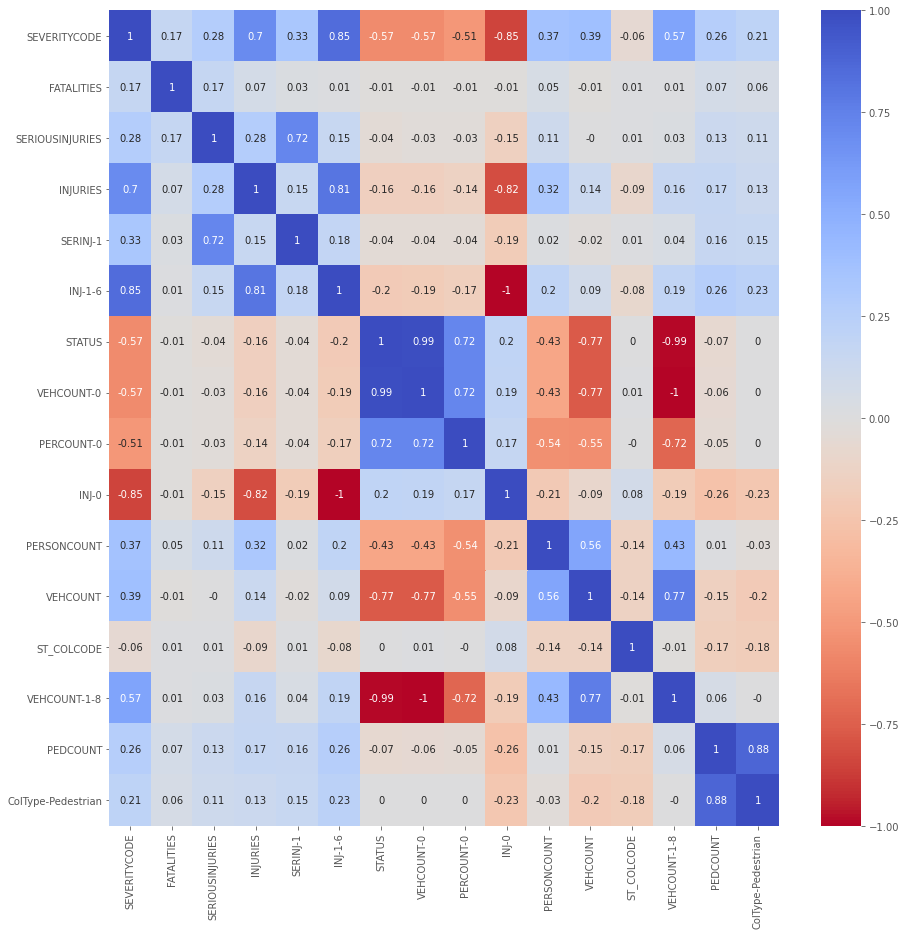

In [155]:
dfx = cormat_heatmap(cols)

In [156]:
# top_features = cormat[cormat.SEVERITYCODE.abs() > 0.2][['SEVERITYCODE']]
# len(top_features)

In [157]:
#dfx = cormat_heatmap(top_features.index.to_list())

In [158]:
top_features = df[cols]#df[top_features.index.to_list()]
top_features.head()

,SEVERITYCODE,FATALITIES,SERIOUSINJURIES,INJURIES,SERINJ-1,INJ-1-6,STATUS,VEHCOUNT-0,PERCOUNT-0,INJ-0,PERSONCOUNT,VEHCOUNT,ST_COLCODE,VEHCOUNT-1-8,PEDCOUNT,ColType-Pedestrian
0,0,0,0,0,0,0,1,1,1,1,0,0,10,0,0,0
1,0,0,0,0,0,0,1,1,1,1,0,0,14,0,0,0
2,1,0,0,0,0,0,0,0,0,1,2,2,28,1,0,0
3,1,0,0,0,0,0,0,0,0,1,2,2,32,1,0,0
4,1,0,0,0,0,0,0,0,0,1,2,2,14,1,0,0


Split the data into training and testing

In [159]:
Y = top_features.SEVERITYCODE
X = top_features.drop('SEVERITYCODE', axis=1)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Use the random forest classifiers since the hierarchical structures of the trees enable them to distinguish the classes even if they are imbalanced

In [161]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

Predict the classes using the test data

In [162]:
y_hat = rfc.predict(X_test)

Compute the accuracy

In [163]:
print('The model achieved an accuracy of %.2f' %(accuracy_score(y_test, y_hat)))

The model achieved an accuracy of 0.99


Please note that although the accuarcy of the model is very high, we are still not sure if the model is doing well! This is so since we have _imbalanced classification_ problem and if one class is overwhelmingly more represented in the data than the other minority classes, __it is possible to obtain a very high accuracy if you model just predicting the majority class.__ For this reasons, it is imperative to make sure that your model is not prediciting a single class.

In [164]:
np.unique(y_hat)

array([0, 1, 2, 3, 4])

Great! The model is predicting all classes

**Compute the average accuracy**

In [166]:
N = 10
avg = 0 # average accuracy
cls = 0 # increment it if all 5 classes are predicted
for i in range(N):
    random_state = np.random.randint(1,1e9)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_hat = rfc.predict(X_test)
    avg += accuracy_score(y_test, y_hat)
    if len(np.unique(y_hat)) == 5: cls += 1
print("Average accuracy over %d runs is %.2f" %(N, avg/N))
print("Percentage of times predicting all 5 classes is %.1f" %(100*cls/N))

Average accuracy over 10 runs is 0.99
Percentage of times predicting all 5 classes is 100.0


# Results & Discussion <a class="anchor" id="rd"></a>

**Accuracy:**   
The predictive models that we built achieves an accuracy of 99% which is very high and is able to predict all five classes despite the fact that the problem is highly _imbalanced_. This ensures that the high accuracy of the model is not due to being very good at predicting the majority class. On contrary, the model high predictive power is due to being able to distinguish all five classes. Random forest classifers is used since its hierarchical structures enables decision trees to effectively distinguish different classes even if the data is imbalanced.

**Data Preprocessing:**  
- Unlike most of the prior studies that replaces the missing values of a categorical variable using the most frequent value, we use a roulette-wheel replacement method which preserves the distribution of the of the categorical variable. 

**Feature Selection:**  
- Although there are a total of 81 features (original + engineered), the model only use 15 features which notably includes the number of injuries, the number of cars, the number of persons, and the statu of the collision. Interestingly, 9 out of the 15 featues are **engineered** which highlights the importance of feature engieering.
- We used _chi test_ together with the correlation matrix to select the top features.

**Important Observations Based on Exploratory Data Analysis:**  
- Surprisingly, the geographic data tends to be insignificant for this problem. The target label is very _weakly correlated_ with the locations at which the collisions occur.

- The under-influence-of-alcohol state does not influence the severity of the accident which counters our intuition. In particular, the data reveals that the distribution of the severity of the accident remains invariant with the under-influence-of-alcohol state.

- The poor weather and road conditions do not cause sever accidents. This could possibly be explained by the extra care exercised by the drivers under poor weather or road conditions. 

- Accidents at the intersection are more sever than those in alleys and blocks.

**Recommendations:**
- The most sever accident involved pedestrians and bicyclers. Therefore, better policies to ensure the safety of  pedestrians and bicyclers are needed.
- Accidents at intersection are more sever than those in alleys and blocks. This needs to be investigated physically to see whether these intersections have working traffic lights. If not, perhaps, installing new ones will reduce the number of accidents.
- Though very important, car speeding is mostly missing! This could be due to the difficulty of measuring the exact speed just before the accidents. However, we believe it is a very important predictive feature that should be better recorded.


# Conclusion <a class="anchor" id="conc"></a>

The project aims at predicting the severity of car accident using data acquired from the Seattle City, US.The data is rich with 40 features and 221144 records. 

The problem we dealt with is _imbalanced_ as the number of records across classes. Therefore, we carefully chose the random forest classifiers owing to its power in distinguishing different _imbalanced_ classes as this study showed. We ignored the **resampling** technique to balance the classes since the up-sampling will unacceptably increase the size of the data and the down-sampling will reduce it significantly.

The model is highly accurate (achieved an accuracy of 99%) and is able to predict all five classes which ensured that the high accuracy is not solely produced by predicting the majority class.
